In [8]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [9]:
import os
import datetime
import io
import pickle
import re
import json
import gzip
import cProfile
import lxml.etree
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
# import ray
import scipy.stats
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon, box
import geopandas as geopd
import pandas as pd
import querier as qr
from adjustText import adjust_text
from dotenv import load_dotenv
load_dotenv()

import ses_ling.data.socioeconomic as ses_data
import ses_ling.data.access as data_access
import ses_ling.utils.paths as path_utils
import ses_ling.utils.stats as stats_utils
import ses_ling.utils.geometry as geo_utils
import ses_ling.utils.spatial_agg as spatial_agg
import ses_ling.utils.text_process as text_process
import ses_ling.visualization.utils as viz_utils
import ses_ling.visualization.ses as ses_viz
from ses_ling.language import Language
from ses_ling.region import Region

In [20]:
from matplotlib import font_manager
font_files = font_manager.findSystemFonts()
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

Matplotlib is building the font cache; this may take a moment.


In [33]:
annotate_kwargs = {'fontfamily': 'URW Palladio L', 'fontsize': 12}
fig_width = 11.9 / 2.54

In [26]:
paths = path_utils.ProjectPaths()
all_cntr_shapes = geopd.read_file(paths.countries_shapefile)

In [27]:
with open(paths.ext_data / 'countries.json') as f:
    countries_dict = json.load(f)
cc = 'GB'
cc_dict = countries_dict[cc]
year_from = 2015
year_to = 2021
res_attr_kwargs = dict(
    nighttime_acty_th=0.5,
    all_acty_th=0.1,
    count_th=3,
    gps_dups_th=500,
    pois_dups_th=500,
)

In [28]:
_cc_init_params = {
    cc: {'cell_size': 'MSOA_BGC', 'ses_idx': "IMD", "res_cell_size": "MSOA_BGC"}
}
lang = Language(
    'en', 'English', _cc_init_params, countries_dict,
    all_cntr_shapes=all_cntr_shapes,
    year_from=year_from, year_to=year_to,
    latlon_proj=cc_dict['xy_proj'], # TOCHANGE when several countries
    user_nr_words_th=100,
    cells_nr_users_th=15,
    res_attr_kwargs=res_attr_kwargs,
)
reg = lang.regions[0]

shape_geodf loaded for GB
ses_df loaded for GB
cell_levels_corr loaded for GB
lt_rules loaded for GB
regions done
done


In [ ]:
lang.reload_countries_dict()

# Setup

In [29]:
lang.add_ses_idx('all')

In [397]:
lang.change_cell_sizes(GB='MSOA_BGC')

In [ ]:
fig, ax = plt.subplots()
x = wavg_ses['net_income']
y = uavg_cat_freq['GRAMMAR']
r = y.to_frame().corrwith(x).values[0]
ax = sns.regplot(x=x, y=y, scatter_kws={'alpha': .4}, line_kws={'label': f'r = {r:.2f}'})
ax.legend()

In [30]:
focus_cities = [
    'London', 'Manchester', 'Birmingham', 'Liverpool', 'Leeds', 'Sheffield', 
    'Newcastle upon Tyne', 'Bristol, City of'
]
subregions_dict = {c: 'rgn20nm' if c == 'London' else 'lad20nm' for c in focus_cities}
subreg_df = pd.DataFrame.from_dict({'GB': subregions_dict}, orient='index').stack().rename_axis(index=['cc', 'subreg']).rename('agg_col').to_frame().set_index('agg_col', append=True)

metro_areas = pd.read_csv(lang.paths.ext_data / lang.regions[0].cell_levels_corr_files['metro_area'])
subreg_df = subreg_df.join(metro_areas.set_index('metro_area')['LAD20CD'], on='subreg')

## Check consistency real pop / twitter pop ratio

In [71]:
pop_d = {}
for city, city_d in lang.iter_subregs(subreg_df, ses_metric='total_pop'):
    pop_d[city] = {}
    pop_d[city]['nr_users'] = city_d['user_res_cell'].groupby('cell_id').size().sum()
    pop_d[city]['total_pop'] = city_d['cells_ses_metric'].sum()
pop_df = pd.DataFrame.from_dict(pop_d, orient='index').rename_axis('city')

285 cells in Birmingham.
55 cells in Bristol, City of.
168 cells in Leeds.
139 cells in Liverpool.
983 cells in London.
306 cells in Manchester.
145 cells in Newcastle upon Tyne.
103 cells in Sheffield.


Text(0, 0.5, 'Number of residents found on Twitter')

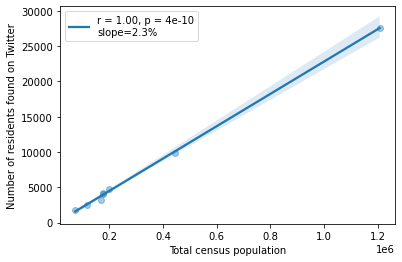

In [100]:
fig, ax = plt.subplots()
x = [d['total_pop'] for k, d in pop_d.items()]
y = [d['nr_users'] for k, d in pop_d.items()]
# annots = [ax.text(d['total_pop'], d['nr_users'], k) for k, d in pop_d.items()]
reg_res = scipy.stats.linregress(x, y)
ax = sns.regplot(
    x=x,
    y=y,
    scatter_kws={'alpha': .4},
    line_kws={'label': f'r = {r:.2f}, p = {p:.0e}\nslope={reg_res.slope:.1%}'},
    ax=ax,
)
# adj_text_kw = {'arrowprops': {'arrowstyle': '-', 'color': 'gray', 'lw': 0.1}}
# adjust_text(annots, x=x, y=y, ax=ax, **adj_text_kw)
ax.legend()
ax.set_xlabel("Total census population")
ax.set_ylabel('Number of residents found on Twitter')

Text(0, 0.5, 'Number of residents found on Twitter')

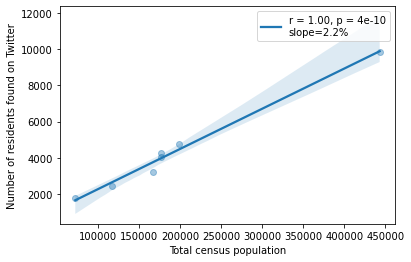

In [101]:
fig, ax = plt.subplots()
x = [d['total_pop'] for k, d in pop_d.items() if k != 'London']
y = [d['nr_users'] for k, d in pop_d.items() if k != 'London']
reg_res = scipy.stats.linregress(x, y)
ax = sns.regplot(
    x=x,
    y=y,
    scatter_kws={'alpha': .4},
    line_kws={'label': f'r = {r:.2f}, p = {p:.0e}\nslope={reg_res.slope:.1%}'},
    ax=ax,
)
ax.legend()
ax.set_xlabel("Total census population")
ax.set_ylabel('Number of residents found on Twitter')

In [674]:
# isin_region = lang.make_subregions_mask(subreg_df, set_cells_mask=True)
del lang.cells_mask
# lang.cells_mask = (
#     lang.cells_mask
#     & isin_region
# )

# Corr grammar x net income

983 cells in London.
57 cells in Manchester.
132 cells in Birmingham.
61 cells in Liverpool.
107 cells in Leeds.
70 cells in Sheffield.
55 cells in Bristol, City of.


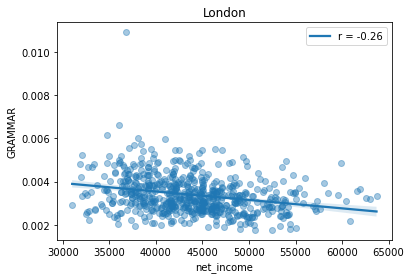

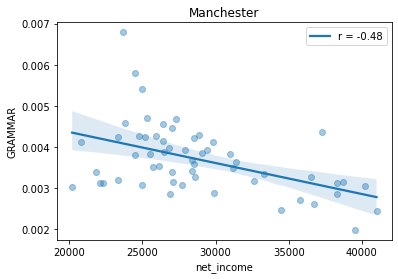

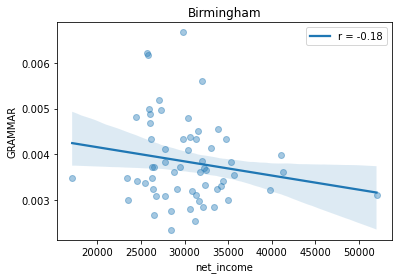

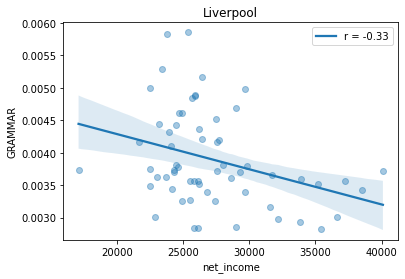

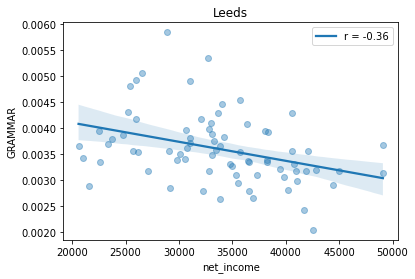

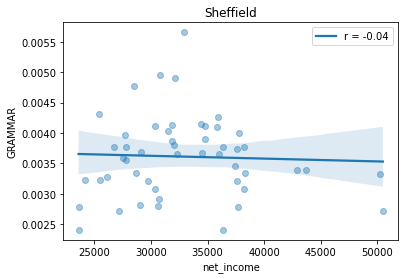

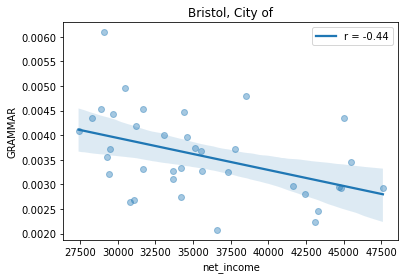

In [679]:
for city, city_df in subreg_df.groupby('subreg'):
    reg_mask = lang.make_subregions_mask(city_df, set_cells_mask=False)
    fig, ax = plt.subplots()
    x = wavg_ses.loc[reg_mask.loc[reg_mask].index, 'net_income']
    y = uavg_cat_freq.loc[reg_mask.loc[reg_mask].index, 'GRAMMAR']
    r = y.to_frame().corrwith(x).values[0]
    ax = sns.regplot(x=x, y=y, scatter_kws={'alpha': .4}, line_kws={'label': f'r = {r:.2f}'})
    ax.legend()
    ax.set_title(city)

### Paper plots

** London **
983 cells in London.
652 cells left after masking cells where there are fewer than  15 residents
** Manchester **
306 cells in Manchester.
262 cells left after masking cells where there are fewer than  15 residents
** Sheffield **
103 cells in Sheffield.
68 cells left after masking cells where there are fewer than  15 residents


Text(0.02, 0.5, 'Average frequency of grammar mistakes (per thousand words)')

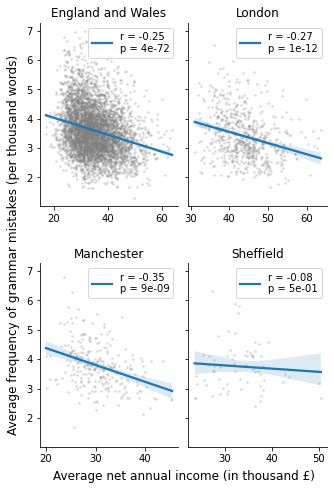

In [194]:
fig, axd = plt.subplot_mosaic(
    [
        ['a', 'b'],
        ['c', 'd']
    ],
    figsize=(fig_width, 17 / 2.54), sharey=True, constrained_layout=True,
    gridspec_kw={'wspace': 0, 'hspace': 0.1}
)
ses_id = 'net_income18'
cat_id = 'GRAMMAR'
ses_values = lang.select_ses_metric(ses_id)
mistake_values = lang.select_mistakes(cat_id=cat_id)
mistake_ol_mask = stats_utils.mask_outliers(mistake_values, iqr_mult=3).reindex(mistake_values.index).fillna(False)
ses_ol_mask = stats_utils.mask_outliers(ses_values, iqr_mult=3).reindex(ses_values.index).fillna(False)
ol_mask = ses_ol_mask & mistake_ol_mask
r, p = scipy.stats.pearsonr(ses_values.loc[ol_mask], mistake_values.loc[ol_mask])

# plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax = axd['a']
ax = sns.regplot(
    x=ses_values.loc[ol_mask] / 1000,
    y=mistake_values.loc[ol_mask] * 1000,
    scatter_kws={'alpha': .2, 's': 3, 'color': 'gray'},
    line_kws={'label': f'r = {r:.2f}\np = {p:.0e}'}, # 'color': 'gray'},
    ax=ax,
)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend()
ax.set_title("England and Wales")
# ax.annotate(f"(a)", (-0.4, 1.05), xycoords='axes fraction', **annotate_kwargs)
cities = ['Manchester', 'London', 'Sheffield']
loc = (slice(None), cities, slice(None))
for (city, city_d), ax_key in zip(
    lang.iter_subregs(subreg_df.loc[loc, :], ses_metric=ses_id, cat_id=cat_id),
    ['b', 'c', 'd']
):
    ax = axd[ax_key]
    # reg_mask = lang.make_subregions_mask(city_df, set_cells_mask=False)
    # cells_idc = reg_mask.loc[reg_mask].index
    city_d['cells_mask'] = None # already done in lang.iter_subregs
    ses_values = city_d['cells_ses_metric']
    mistake_values = city_d['cells_mistake']
    mistake_ol_mask = stats_utils.mask_outliers(mistake_values, iqr_mult=3).reindex(mistake_values.index).fillna(False)
    ses_ol_mask = stats_utils.mask_outliers(ses_values, iqr_mult=3).reindex(ses_values.index).fillna(False)
    ol_mask = ses_ol_mask & mistake_ol_mask
    r, p = scipy.stats.pearsonr(ses_values.loc[ol_mask], mistake_values.loc[ol_mask])
    ax = sns.regplot(
        x=ses_values.loc[ol_mask] / 1000,
        y=mistake_values.loc[ol_mask] * 1000,
        scatter_kws={'alpha': .2, 's': 3, 'color': 'gray'},
        line_kws={'label': f'r = {r:.2f}\np = {p:.0e}'},
        ax=ax,
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # if ax_key in ['b', 'd']:
    #     ax.spines.left.set_visible(False)
    ax.legend()
    ax.set_title(city)
fig.supxlabel('Average net annual income (in thousand £)', x=0.55)
fig.supylabel('Average frequency of grammar mistakes (per thousand words)')

In [195]:
fig.savefig(lang.paths.case_figs / 'ses_x_grammar_corrs.pdf')

### Maps

In [ ]:
cat_id = 'GRAMMAR' # ['TYPOS', 'CONFUSED_WORDS', 'COMPOUNDING'] #'
ses_id = 'net_income18'
# ses_values = lang.select_ses_metric(ses_id)
# mistake_values = lang.select_mistakes(cat_id=cat_id)
# common_idx = ses_values.index[ses_values.notnull()].intersection(
#     mistake_values.index[mistake_values.notnull()]
# )
# ses_values = ses_values.loc[common_idx]
# mistake_values = mistake_values.loc[common_idx]
# # tooltip_df = lang.cells_ses_df['wavg'].unstack().applymap(lambda f: '{:.2g}'.format(f))

for city, city_d in lang.iter_subregs(subreg_df, ses_metric=ses_id, cat_id=cat_id):
    # reg_mask = lang.make_subregions_mask(city_df, set_cells_mask=False)
    # cells_idc = reg_mask.loc[reg_mask].index
    city_d['cells_mask'] = None # already done in lang.iter_subregs
    ses_values = city_d['cells_ses_metric']
    mistake_values = city_d['cells_mistake']
    mistake_ol_mask = stats_utils.mask_outliers(mistake_values, iqr_mult=3).reindex(mistake_values.index).fillna(False)
    ses_ol_mask = stats_utils.mask_outliers(ses_values, iqr_mult=3).reindex(ses_values.index).fillna(False)
    ol_mask = ses_ol_mask & mistake_ol_mask

    
    r, p = scipy.stats.pearsonr(ses_values.loc[ol_mask], mistake_values.loc[ol_mask])
    fig, ax = plt.subplots()
    ax = sns.regplot(
        x=ses_values.loc[ol_mask],
        y=mistake_values.loc[ol_mask],
        scatter_kws={'alpha': .4},
        line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
        ax=ax,
    )
    ax.legend()
    ax.set_title(city)
    save_path = lang.figs_path / f'corr_{ses_id}_vs_{cat_id}_in_{city}.pdf'
    fig.savefig(save_path, bbox_inches='tight')
    fig.savefig(save_path.with_suffix('.png'), bbox_inches='tight')
    fig.clear()

    save_path = lang.figs_path / f'{mistake_values.name}_of_{cat_id}_in_{city}.html'
    z_plot = mistake_values.loc[mistake_ol_mask]
    cbar_label = f'User average of word frequency of {z_plot.name}'
    m = lang.map_interactive(
        z_plot,# tooltip_df=tooltip_df.loc[cells_idc],
        save_path=save_path
    )
    fig, axes = lang.map_continuous_choro(
        z_plot, cmap='plasma', cbar_label=cbar_label,
        save_path=save_path.with_suffix('.pdf'), show=True
    )
    fig.savefig(save_path.with_suffix('.png'), bbox_inches='tight')
    fig.clear()

    save_path = lang.figs_path / f'{ses_id}_in_{city}.html'
    z_plot = ses_values.loc[ses_ol_mask]
    cbar_label = f'{z_plot.name} of {ses_id}'
    m = lang.map_interactive(
        z_plot, cmap='viridis_r',
        # tooltip_df=tooltip_df.loc[cells_idc],
        save_path=save_path
    )
    fig, axes = lang.map_continuous_choro(
        z_plot, cmap='plasma_r', cbar_label=cbar_label,
        save_path=save_path.with_suffix('.pdf'), show=False
    )
    fig.savefig(save_path.with_suffix('.png'), bbox_inches='tight')
    fig.clear()

# Assortativity?

link to mobility segregation?  dispersion in city of SES variables. papers on city ghettos. options fo rmob: twitter, covid mobility (pre-pandemic samples) assortativity index in cities. or from twitter interactions: eg are London users interatting more across cells with different ses than in Manchester 

## From Twitter visited cells

In [199]:
cat_id = ['GRAMMAR'] #'GRAMMAR'
ses_id = 'net_income18'
ses_x_grammar_dict = {}
for city, city_d in lang.iter_subregs(subreg_df, ses_metric=ses_id, cat_id=cat_id):
    # city_d['cells_mask'] = None # already done in lang.iter_subregs
    mistake_values = city_d['cells_mistake']
    ses_values = city_d['cells_ses_metric']
    mistake_ol_mask = stats_utils.mask_outliers(mistake_values, iqr_mult=3).reindex(mistake_values.index).fillna(False)
    ses_ol_mask = stats_utils.mask_outliers(ses_values, iqr_mult=3).reindex(ses_values.index).fillna(False)
    ol_mask = ses_ol_mask & mistake_ol_mask

    r, p = scipy.stats.pearsonr(ses_values.loc[ol_mask], mistake_values.loc[ol_mask])
    ses_x_grammar_dict[city] = {}
    ses_x_grammar_dict[city]['pearsonr'] = r
    ses_x_grammar_dict[city]['p_value'] = p

** Birmingham **
285 cells in Birmingham.
95 cells left after masking cells where there are fewer than  15 residents
** Bristol, City of **
55 cells in Bristol, City of.
41 cells left after masking cells where there are fewer than  15 residents
** Leeds **
168 cells in Leeds.
105 cells left after masking cells where there are fewer than  15 residents
** Liverpool **
139 cells in Liverpool.
122 cells left after masking cells where there are fewer than  15 residents
** London **
983 cells in London.
652 cells left after masking cells where there are fewer than  15 residents
** Manchester **
306 cells in Manchester.
262 cells left after masking cells where there are fewer than  15 residents
** Newcastle upon Tyne **
145 cells in Newcastle upon Tyne.
110 cells left after masking cells where there are fewer than  15 residents
** Sheffield **
103 cells in Sheffield.
68 cells left after masking cells where there are fewer than  15 residents


In [200]:
nr_classes = 5
exclude_res_trips = True
# if normalize_incoming, sum over rows in heatmap = 1
normalize_incoming = False
assort_dict = {}

for city, city_d in lang.iter_subregs(subreg_df, ses_metric='net_income18', include_pop=True):
    assort = ses_data.user_acty_to_assort(
        nr_classes=nr_classes,
        exclude_res_trips=exclude_res_trips,
        normalize_incoming=normalize_incoming,
        **city_d,
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    assort_dict[city] = {'assort': assort, 'pearsonr': pearsonr}

** Birmingham **
285 cells in Birmingham.
95 cells left after masking cells where there are fewer than  15 residents
19.0 cells on average in each of the 5 classes.
34.8% of users and 86.7% of trips removed from exclusion of residence trips
** Bristol, City of **
55 cells in Bristol, City of.
41 cells left after masking cells where there are fewer than  15 residents
8.2 cells on average in each of the 5 classes.
32.1% of users and 84.2% of trips removed from exclusion of residence trips
** Leeds **
168 cells in Leeds.
105 cells left after masking cells where there are fewer than  15 residents
21.0 cells on average in each of the 5 classes.
28.6% of users and 82.7% of trips removed from exclusion of residence trips
** Liverpool **
139 cells in Liverpool.
122 cells left after masking cells where there are fewer than  15 residents
24.4 cells on average in each of the 5 classes.
25.7% of users and 79.2% of trips removed from exclusion of residence trips
** London **
983 cells in London.
65

## Excluding trips to res cell

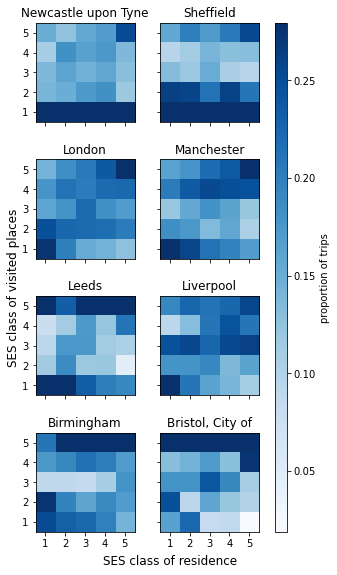

In [188]:
# exclude_res_trips = True, include real pop
fig, axd = ses_viz.assort_mosaic(assort_dict, nr_cols=2, figsize=(fig_width, 20/2.54), gridspec_kw={'wspace': 0.02, 'hspace': 0, 'width_ratios': [0.05, 1, 1, 0.1]})#, 'right': 0.8})

In [189]:
fig.savefig(lang.paths.case_figs / 'cities_SES_mobility.pdf', bbox_inches='tight')

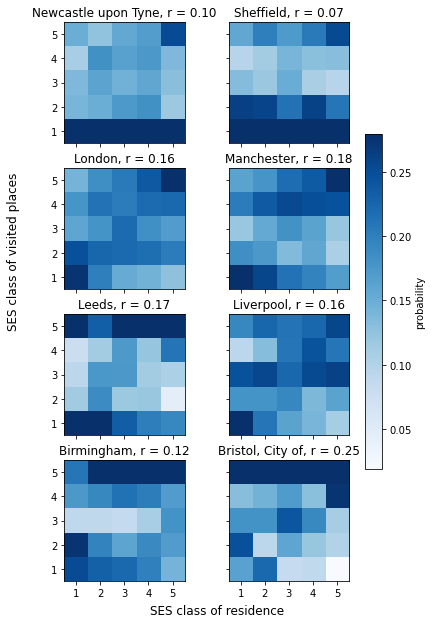

In [309]:
# exclude_res_trips = True, include real pop
fig, axd = ses_viz.assort_mosaic(assort_dict, nr_cols=2, figsize=(15/2.54, 26/2.54))

### What's going on in Leeds?

In [ ]:
exclude_res_trips = False
city = 'Leeds'
cells_mask = lang.make_subregions_mask(subreg_df.loc[('GB', [city]), :], set_cells_mask=False)
masks_dict = {'cell_id': cells_mask}
cells_subset_user_res = ses_data.apply_masks(lang.user_residence_cell, masks_dict)
cells_subset_user_acty = ses_data.preprocess_cell_acty(
    lang.user_cell_acty, cells_subset_user_res, masks_dict, exclude_res_trips
)
od_df = (
    cells_subset_user_acty.groupby(['res_cell_id', 'cell_id'])[['prop_cell']].sum()
)
od_groupby_col = 'cell_id' if normalize_incoming else 'res_cell_id'
od_df = od_df / od_df.groupby(od_groupby_col).transform('sum')

cells_subset_ses_metric = ses_data.apply_masks(cells_ses_metric, masks_dict)
user_class = ses_data.attr_user_to_class(
    cells_subset_user_res, cells_subset_ses_metric, nr_classes
)
cells_class = ses_data.cell_class_from_residents(cells_subset_user_res, user_class)

168 cells in Leeds.
105 cells left after masking cells where there are fewer than  15 residents
850.6 users on average in each of the 5 classes.


In [ ]:
a = cells_subset_user_acty.join(cells_class).join(cells_class.rename('res_cell_class'), on='res_cell_id')

In [ ]:
od_matrix_coords_mask = (a['cell_class'] == 5) & (a['res_cell_class'] == 1)
# origins of 1 -> 5 trips
z_plot = a.loc[od_matrix_coords_mask].groupby('res_cell_id')['prop_cell'].sum()
lang.map_interactive(z_plot)

In [ ]:
od_matrix_coords_mask = (a['cell_class'] == 1) & (a['res_cell_class'] == 5)
# origins of 5 -> 1 trips
z_plot = a.loc[od_matrix_coords_mask].groupby('res_cell_id')['prop_cell'].sum()
lang.map_interactive(z_plot)

In [ ]:
# destinations of 5 -> 1 trips
z_plot = a.loc[od_matrix_coords_mask].groupby('cell_id')['prop_cell'].sum()
lang.map_interactive(z_plot)

what if we remove city centre cell?


In [ ]:
exclude_res_trips = True
city = 'Leeds'
cells_mask = lang.make_subregions_mask(subreg_df.loc[('GB', [city]), :], set_cells_mask=False)
cells_mask.loc['E02006875'] = False
masks_dict = {'cell_id': cells_mask}
cells_subset_user_res = ses_data.apply_masks(lang.user_residence_cell, masks_dict)
cells_subset_user_acty = ses_data.preprocess_cell_acty(
    lang.user_cell_acty, cells_subset_user_res, masks_dict, exclude_res_trips
)
od_df = (
    cells_subset_user_acty.groupby(['res_cell_id', 'cell_id'])[['prop_cell']].sum()
)
od_groupby_col = 'cell_id' if normalize_incoming else 'res_cell_id'
od_df = od_df / od_df.groupby(od_groupby_col).transform('sum')

cells_subset_ses_metric = ses_data.apply_masks(cells_ses_metric, masks_dict)

cells_pop = lang.select_ses_metric('total_pop', 'weight')
cells_pop = ses_data.apply_masks(cells_pop, masks_dict)
cells_class = ses_data.attr_cell_to_class(
    cells_subset_ses_metric, nr_classes, cells_pop
)
user_class = cells_subset_user_res.join(cells_class, on='cell_id')[cells_class.name]
# user_class = ses_data.attr_user_to_class(
#     cells_subset_user_res, cells_subset_ses_metric, nr_classes
# )
# cells_class = ses_data.cell_class_from_residents(cells_subset_user_res, user_class)
interclass_od = ses_data.inter_cell_to_inter_class_od(
    od_df,
    cells_class,
    weight_col='prop_cell',
)
assort = ses_data.interclass_od_to_assort(
    interclass_od, normalize_incoming=normalize_incoming
)
pearsonr = stats_utils.matrix_pearsonr(assort.values)
print(pearsonr)

168 cells in Leeds.
105 cells left after masking cells where there are fewer than  15 residents
34.8% of users and 85.9% of trips removed from exclusion of residence trips
20.8 cells on average in each of the 5 classes.
0.2598362613266046


In [ ]:
mistake_values = lang.select_mistakes(cat_id='GRAMMAR')
mistake_values = ses_data.apply_masks(mistake_values, masks_dict)
ses_values = cells_subset_ses_metric.copy()
mistake_ol_mask = stats_utils.mask_outliers(mistake_values, iqr_mult=3).reindex(mistake_values.index).fillna(False)
ses_ol_mask = stats_utils.mask_outliers(ses_values, iqr_mult=3).reindex(ses_values.index).fillna(False)
ol_mask = ses_ol_mask & mistake_ol_mask

r, p = scipy.stats.pearsonr(ses_values.loc[ol_mask], mistake_values.loc[ol_mask])
print(r)

-0.29275183642175406


-> not much change

### Pearson r mistakes vs assort

Text(-0.999760000000002, 0.5, "Assortativity matrix' pearson r")

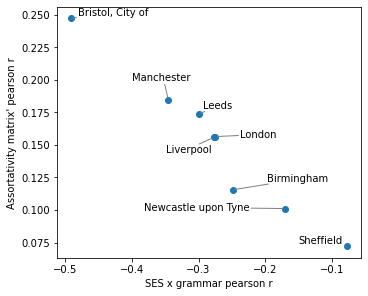

In [35]:
fig, ax = plt.subplots(figsize=(7.8 / 2.54, 6 / 2.54), constrained_layout=True)
cities = ses_x_grammar_dict.keys()
x = [ses_x_grammar_dict[city]['pearsonr'] for city in cities]
y = [assort_dict[city]['pearsonr'] for city in cities]
annots = [ax.annotate(city, (xc, yc)) for city, xc, yc in zip(cities, x, y)]
ax.scatter(x, y)
adj_text_kw = {
    'expand_points': (1.2, 1.5),
    'expand_text': (1.2, 2),
    'arrowprops': {'arrowstyle': '-', 'color': 'gray', 'lw': 1},
}
adjust_text(annots, x=x, y=y, ax=ax, **adj_text_kw)
ax.set_xlabel('SES x grammar pearson r')
ax.set_ylabel("Assortativity matrix' pearson r")

In [36]:
fig.savefig('uk_metro_assort_vs_corr_ses_grammar.pdf')

### Freq mistakes vs assort

In [201]:
avg_grammar_dict = {}
cat_id = ['GRAMMAR'] #'GRAMMAR'
for city, city_d in lang.iter_subregs(subreg_df, ses_metric=ses_id, cat_id=cat_id):
    # city_d['cells_mask'] = None # already done in lang.iter_subregs
    mistake_values = city_d['cells_mistake']
    ses_values = city_d['cells_ses_metric']
    users_pop = city_d['user_res_cell'].groupby('cell_id').size()
    avg_mistake_ufreq = (mistake_values * users_pop).sum() / users_pop.sum()
    avg_grammar_dict[city] = avg_mistake_ufreq

** Birmingham **
285 cells in Birmingham.
95 cells left after masking cells where there are fewer than  15 residents
** Bristol, City of **
55 cells in Bristol, City of.
41 cells left after masking cells where there are fewer than  15 residents
** Leeds **
168 cells in Leeds.
105 cells left after masking cells where there are fewer than  15 residents
** Liverpool **
139 cells in Liverpool.
122 cells left after masking cells where there are fewer than  15 residents
** London **
983 cells in London.
652 cells left after masking cells where there are fewer than  15 residents
** Manchester **
306 cells in Manchester.
262 cells left after masking cells where there are fewer than  15 residents
** Newcastle upon Tyne **
145 cells in Newcastle upon Tyne.
110 cells left after masking cells where there are fewer than  15 residents
** Sheffield **
103 cells in Sheffield.
68 cells left after masking cells where there are fewer than  15 residents


Text(14.25, 0.5, "Assortativity matrix' pearson r")

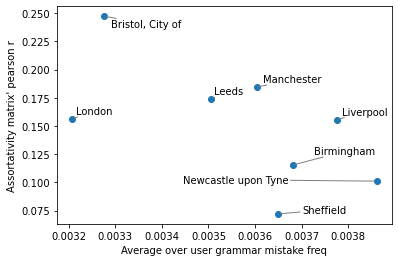

In [25]:
fig, ax = plt.subplots()
cities = ses_x_grammar_dict.keys()
x = [avg_grammar_dict[city] for city in cities]
y = [assort_dict[city]['pearsonr'] for city in cities]
annots = [ax.annotate(city, (xc, yc)) for city, xc, yc in zip(cities, x, y)]
ax.scatter(x, y)
adj_text_kw = {
    'expand_points': (1.2, 1.5),
    'expand_text': (1.2, 3),
    'arrowprops': {'arrowstyle': '-', 'color': 'gray', 'lw': 1},
}
adjust_text(annots, x=x, y=y, ax=ax, **adj_text_kw)
ax.set_xlabel('Average over user grammar mistake freq')
ax.set_ylabel("Assortativity matrix' pearson r")

So more mixing -> more mistakes kinda

Paper plot

Text(0.5, -0.999760000000002, 'Assortativity')

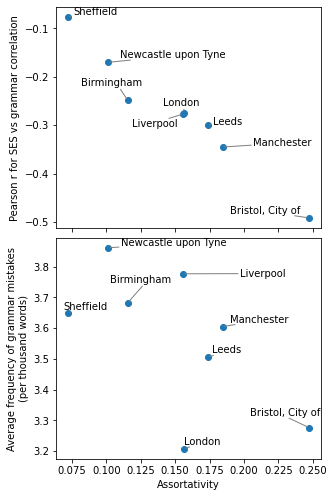

In [210]:
fig, axes = plt.subplots(2, figsize=(fig_width, 1.5*fig_width), constrained_layout=True, sharex=True)
ax = axes[0]
cities = ses_x_grammar_dict.keys()
y = [ses_x_grammar_dict[city]['pearsonr'] for city in cities]
x = [assort_dict[city]['pearsonr'] for city in cities]
annots = [ax.annotate(city, (xc, yc)) for city, xc, yc in zip(cities, x, y)]
ax.scatter(x, y)
adj_text_kw = {
    'expand_points': (1.2, 1.5),
    'expand_text': (1.2, 2),
    'arrowprops': {'arrowstyle': '-', 'color': 'gray', 'lw': 1},
}
adjust_text(annots, x=x, y=y, ax=ax, **adj_text_kw)
ax.set_ylabel('Pearson r for SES vs grammar correlation')
# ax.set_xlabel("Assortativity")

ax = axes[1]
# ax.sharex(axes[0])
cities = ses_x_grammar_dict.keys()
y = np.asarray([avg_grammar_dict[city] for city in cities]) * 1000
x = [assort_dict[city]['pearsonr'] for city in cities]
annots = [ax.annotate(city, (xc, yc)) for city, xc, yc in zip(cities, x, y)]
ax.scatter(x, y)
adj_text_kw = {
    'expand_points': (1.2, 1.5),
    'expand_text': (1.2, 3),
    'arrowprops': {'arrowstyle': '-', 'color': 'gray', 'lw': 1},
}
adjust_text(annots, x=x, y=y, ax=ax, **adj_text_kw)
ax.set_ylabel('Average frequency of grammar mistakes\n(per thousand words)')
ax.set_xlabel("Assortativity")

In [211]:
fig.savefig(lang.paths.case_figs / 'cities_assort_vs_grammar_and_SES_corr.pdf')

## Including trips to res cell

In [ ]:
nr_classes = 5
exclude_res_trips = False
# if normalize_incoming, sum over rows in heatmap = 1
normalize_incoming = False
assort_dict = {}

for city, city_d in lang.iter_subregs(subreg_df, ses_metric='net_income18', include_pop=True):
    assort = ses_data.user_acty_to_assort(
        nr_classes=nr_classes,
        exclude_res_trips=exclude_res_trips,
        normalize_incoming=normalize_incoming,
        **city_d,
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    assort_dict[city] = {'assort': assort, 'pearsonr': pearsonr}

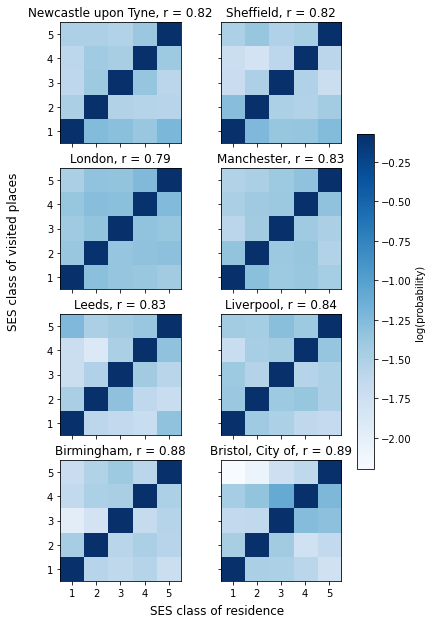

In [258]:
# exclude_res_trips = False
fig, axd = ses_viz.assort_mosaic(
    assort_dict, nr_cols=2, figsize=(15/2.54, 26/2.54), log_scale=True
)

Text(0, 0.5, "Assortativity matrix' pearson r")

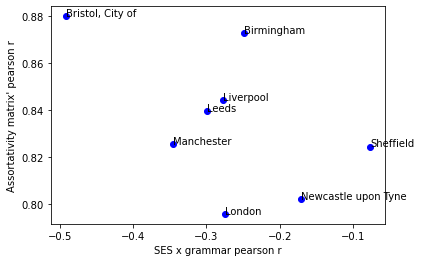

In [313]:
# including real pop
fig, ax = plt.subplots()
for city in ses_x_grammar_dict.keys():
    x = ses_x_grammar_dict[city]['pearsonr']
    y = assort_dict[city]['pearsonr']
    ax.scatter(x, y, c='b')
    ax.annotate(city, (x, y))
ax.set_xlabel('SES x grammar pearson r')
ax.set_ylabel("Assortativity matrix' pearson r")

## Forcing same set of users

In [314]:
nr_classes = 5
# if normalize_incoming, sum over rows in heatmap = 1
normalize_incoming = False
assort_dict = {}

for city, city_d in lang.iter_subregs(subreg_df, ses_metric='net_income18', include_pop=True):
    assort_dict[city] = {}
    masks_dict = {'cell_id': city_d['cells_mask']}
    exclude_res_trips = True
    assort = ses_data.user_acty_to_assort(
        nr_classes=nr_classes,
        exclude_res_trips=exclude_res_trips,
        normalize_incoming=normalize_incoming,
        **city_d,
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    assort_dict[city][exclude_res_trips] = {'assort': assort, 'pearsonr': pearsonr}
    cells_subset_user_acty = ses_data.preprocess_cell_acty(
        city_d['user_cell_acty'], city_d['user_res_cell'], masks_dict, exclude_res_trips
    )
    users_mask = pd.Series(False, index=city_d['user_res_cell'].index, name='in')
    uidc = cells_subset_user_acty.index.get_level_values('user_id').unique()
    users_mask.loc[uidc] = True

    exclude_res_trips = False
    assort = ses_data.user_acty_to_assort(
        nr_classes=nr_classes,
        exclude_res_trips=exclude_res_trips,
        normalize_incoming=normalize_incoming,
        users_mask=users_mask,
        **city_d,
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    assort_dict[city][exclude_res_trips] = {'assort': assort, 'pearsonr': pearsonr}


** Birmingham **
285 cells in Birmingham.
95 cells left after masking cells where there are fewer than  15 residents
19.0 cells on average in each of the 5 classes.
34.8% of users and 86.7% of trips removed from exclusion of residence trips
34.8% of users and 86.7% of trips removed from exclusion of residence trips
19.0 cells on average in each of the 5 classes.
** Bristol, City of **
55 cells in Bristol, City of.
41 cells left after masking cells where there are fewer than  15 residents
8.2 cells on average in each of the 5 classes.
32.1% of users and 84.2% of trips removed from exclusion of residence trips
32.1% of users and 84.2% of trips removed from exclusion of residence trips
8.2 cells on average in each of the 5 classes.
** Leeds **
168 cells in Leeds.
105 cells left after masking cells where there are fewer than  15 residents
21.0 cells on average in each of the 5 classes.
28.6% of users and 82.7% of trips removed from exclusion of residence trips
28.6% of users and 82.7% of t

Text(0, 0.5, "Assortativity matrix' pearson r")

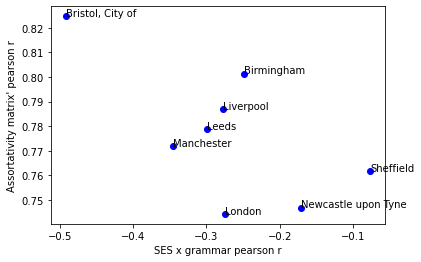

In [316]:
fig, ax = plt.subplots()
for city in ses_x_grammar_dict.keys():
    x = ses_x_grammar_dict[city]['pearsonr']
    y = assort_dict[city][False]['pearsonr']
    ax.scatter(x, y, c='b')
    ax.annotate(city, (x, y))
ax.set_xlabel('SES x grammar pearson r')
ax.set_ylabel("Assortativity matrix' pearson r")

In [401]:
rng = np.random.default_rng()
rnd_assort = np.zeros_like(assort)
nr_iter = 100
for _ in tqdm(range(nr_iter)):
    rnd_user_acty = ses_data.rewire_user_cell_acty(
        subreg_user_cell_acty, lang.user_residence_cell, rng,
        exclude_res_trips=exclude_res_trips
    )
    rnd_od_df = (
        rnd_user_acty.groupby(['res_cell_id', 'cell_id'])[['prop_cell']].sum()
    )
    rnd_od_df = rnd_od_df / rnd_od_df.groupby(od_groupby_col).transform('sum')
    rnd_interclass_od = ses_data.inter_cell_to_inter_class_od(
        rnd_od_df,
        cells_class.loc[cells_mask],
        weight_col='prop_cell'
    )
    rnd_assort = rnd_assort + ses_data.interclass_od_to_assort(
        rnd_interclass_od, normalize_incoming=normalize_incoming
    )
rnd_assort = rnd_assort / nr_iter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.73it/s]


In [402]:
assort / rnd_assort

to_net_income18,1,2,3,4,5
from_net_income18,,,,,
1,0.912334,0.806823,0.681424,4.767255,0.698196
2,0.827754,0.818944,0.666239,5.599743,0.555857
3,0.587446,0.572704,0.756593,7.873770,0.910638
4,0.552364,0.305348,1.484816,10.807581,1.203063
5,0.259800,0.379411,1.277969,6.835770,2.147101


In [466]:
assort.values.sum(axis=1-int(normalize_incoming))

array([1., 1., 1., 1., 1.])

## Regression with those + income?

In [858]:
cell_residents_entropy = lang.user_residence_cell.join(user_visited_cells_entropy, how='inner').groupby('cell_id')['visited_entropy'].mean().rename('residents_entropy')

In [883]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

In [875]:
X = cells_subset_ses_metric.to_frame()
y = lang.select_mistakes(cat_id=['GRAMMAR']).loc[reg_mask]
print(X.isnull().sum(), X.shape, y.shape)

scaler = StandardScaler().fit(X.values)
X_rescaled = scaler.transform(X.values)

reg = RandomForestRegressor(oob_score=True, random_state=1)
reg = reg.fit(X_rescaled, y)
reg.score(X_rescaled, y), reg.oob_score_

net_income18    0
dtype: int64 (652, 1) (652,)


(0.3857084774145446, -0.14967452665742487)

In [876]:
X = pd.concat(
    [
        cells_subset_ses_metric,
        cell_visitors_entropy,
        cell_residents_entropy,
    ],
    axis=1,
)
y = lang.select_mistakes(cat_id=['GRAMMAR']).loc[reg_mask]
print(X.isnull().sum(), X.shape, y.shape)

scaler = StandardScaler().fit(X.values)
X_rescaled = scaler.transform(X.values)

reg = RandomForestRegressor(oob_score=True, random_state=1)
reg = reg.fit(X_rescaled, y)
print(reg.score(X_rescaled, y), reg.oob_score_)

net_income18         0
visitors_entropy     0
residents_entropy    0
dtype: int64 (652, 3) (652,)


(0.8659200629778985, 0.017294581028106326)

In [880]:
def keep_subset_subreg(subreg_df, subset):
    return subreg_df.loc[(slice(None), subset, slice(None)), :]

In [1026]:
cells_subset_user_acty.head()

count  \
user_id                                            cell_id            
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900    3.0   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905    2.0   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957    2.0   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905    1.0   
                                                   E02006898    1.0   

                                                              prop_user  \
user_id                                            cell_id                
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900        1.0   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905        1.0   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957        1.0   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905        0.5   
                                                   E02006898        0.5   

                                                             res_cell_id  \
user_id                                            cell_id                 
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900   E02002012   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905   E02006897   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957   E02001952   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905   E02006899   
                                                   E02006898   E02006899   

                                                              isin_area  \
user_id                                            cell_id                
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900       True   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905       True   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957       True   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905       True   
                                                   E02006898       True   

                                                              cell_class  \
user_id                                            cell_id                 
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900           2   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905           4   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957           3   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905           4   
                                                   E02006898           4   

                                                              user_class  
user_id                                            cell_id                
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900           1  
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905           2  
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957           1  
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905           5  
                                                   E02006898           5

In [1024]:
exclude_res_trips = True
nr_classes = 5
subset_subreg = keep_subset_subreg(subreg_df, ['London'])

for city, reg_mask in lang.iter_subregs(subreg_df):
    cells_subset_user_res = ses_data.get_cells_subset_user_res(
        lang.user_residence_cell, cells_mask=reg_mask
    )
    cells_subset_ses_metric = ses_data.get_cells_subset_ses_metric(
        cells_ses_metric, reg_mask
    )
    user_class = ses_data.attr_user_to_class(
        cells_subset_user_res, cells_subset_ses_metric, nr_classes
    )
    cells_class = (
        cells_subset_user_res.join(user_class)
         .groupby('cell_id')[user_class.name]
         .first()
         .rename('cell_class')
    )
    cells_subset_user_acty = ses_data.get_cells_subset_user_acty(
        user_cell_acty, cells_subset_user_res,
        cells_mask=reg_mask, exclude_res_trips=exclude_res_trips
    )
    cells_subset_user_acty = cells_subset_user_acty.join(cells_class).join(user_class)

    user_visited_cells_entropy = -1 / nr_classes * (cells_subset_user_acty['prop_cell'] * np.log(cells_subset_user_acty['prop_cell'])).groupby('user_id').sum().rename('visited_entropy')

    acty_col = 'count' # count barely any difference with prop_cell
    user_class_acty = cells_subset_user_acty.groupby(['user_class', 'cell_id'])[acty_col].sum().to_frame()
    user_class_acty['prop'] = user_class_acty[acty_col] / user_class_acty[acty_col].groupby('user_class').transform('sum')
    cell_visitors_entropy = -1 / nr_classes * (user_class_acty['prop'] * np.log(user_class_acty['prop'])).groupby('cell_id').sum().rename('visitors_entropy')

    cell_residents_entropy = lang.user_residence_cell.join(user_visited_cells_entropy, how='inner').groupby('cell_id')['visited_entropy'].mean().rename('residents_entropy')

    X = pd.concat(
        [
            cells_subset_ses_metric,
            cell_visitors_entropy,
            cell_residents_entropy,
        ],
        axis=1,
    )
    y = lang.select_mistakes(cat_id=['GRAMMAR']).loc[reg_mask]
    scaler = StandardScaler().fit(X)
    X_rescaled = scaler.transform(X)

    reg = RandomForestRegressor(oob_score=True, random_state=1)
    reg = reg.fit(X_rescaled, y)
    print(
        f"RandomForestRegressor score: {reg.score(X_rescaled, y)} ", 
        f"Out-of-bag score: {reg.oob_score_} ",
        reg.feature_importances_
    )

    ridge = RidgeCV(cv=None).fit(X_rescaled, y, )
    print(
        f"Ridge CV best score: {ridge.best_score_} ",
        # f"coefs: {ridge.coef_} ",
        {
            feature: importance
            for feature, importance in sorted(
                zip(scaler.feature_names_in_, ridge.coef_),
                key=lambda t: np.abs(t[1])
            )
        },
    )

285 cells in Birmingham.
642.6 users on average in each of the 5 classes.


## From census commuting OD

In [25]:
lang.cells_ses_df.loc[(slice(None), ['net_income18', 'net_income_after_housing18']), 'wavg'].unstack().describe()

metric,net_income18,net_income_after_housing18
count,7201.000000,7201.000000
mean,34489.029301,28104.749340
std,7060.623530,5661.093308
min,17100.000000,12500.000000
25%,29200.000000,24200.000000
50%,33600.000000,28000.000000
75%,38900.000000,31700.000000
max,65300.000000,52200.000000


In [ ]:
lang.change_cell_sizes(GB='MSOA_BGC')

In [24]:
lang.add_ses_idx(['net_income18', 'net_income_after_housing18']) #, 'net_income_after_housing'])

In [559]:
commuting_od = pd.read_csv(lang.paths.ext_data / 'wu01ew_v2.csv.gz').rename(columns={'Area of residence': 'res_cell_id', 'Area of workplace': 'cell_id'}).set_index(['res_cell_id', 'cell_id'])['All categories: Sex'].rename('count').to_frame()

In [565]:
cells_ses_metric = lang.select_ses_metric('net_income18')
nr_classes = 5
exclude_res_trips = False
# if normalize_incoming, sum over rows in heatmap = 1
normalize_incoming = False
od_groupby_col = 'cell_id' if normalize_incoming else 'res_cell_id'
assort_dict = {}
for city, city_df in subreg_df.groupby('subreg'):
    reg_mask = lang.make_subregions_mask(city_df, set_cells_mask=False)
    reg_cells = cells_mask.loc[cells_mask]
    od_df = (
        commuting_od.join(reg_cells.rename_axis('res_cell_id'), how='inner')[['count']]
         .join(reg_cells.rename_axis('cell_id'), how='inner')[['count']]
    )
    nr_residents_per_cell = od_df.groupby('res_cell_id')['count'].sum()
    if exclude_res_trips:
        od_df = od_df.loc[od_df.index.get_level_values(0) != od_df.index.get_level_values(1)]
    od_df = od_df / od_df.groupby(od_groupby_col).transform('sum')

    subreg_cells_ses_metric = cells_ses_metric.loc[reg_cells.index]
    cells_class = ses_data.attr_cell_to_class(
        subreg_cells_ses_metric, nr_classes, nr_residents_per_cell
    )
    interclass_od = ses_data.inter_cell_to_inter_class_od(
        od_df,
        cells_class.loc[cells_mask],
        # weight_col='prop_cell'
    )
    assort = ses_data.interclass_od_to_assort(
        interclass_od, normalize_incoming=normalize_incoming
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    assort_dict[city] = {'assort': assort, 'pearsonr': pearsonr}

983 cells in London.
130.4 cells on average in each of the 5 classes.
57 cells in Manchester.
11.4 cells on average in each of the 5 classes.
132 cells in Birmingham.
12.2 cells on average in each of the 5 classes.
61 cells in Liverpool.
12.0 cells on average in each of the 5 classes.
107 cells in Leeds.
14.6 cells on average in each of the 5 classes.
70 cells in Sheffield.
10.4 cells on average in each of the 5 classes.
55 cells in Bristol, City of.
8.2 cells on average in each of the 5 classes.


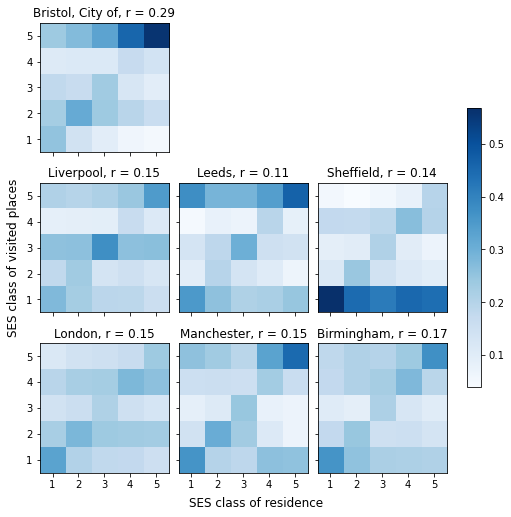

In [566]:
nr_cols = 3
mosaic = list(assort_dict.keys())
nr_empty = nr_cols - len(mosaic) % nr_cols
nr_rows = len(mosaic) // nr_cols + int(nr_empty > 0)
mosaic.extend(['.'] * nr_empty)
mosaic = np.vstack([
    np.array(mosaic).reshape(nr_rows, nr_cols),
    # np.array(['cax'] * nr_cols)
])[::-1, :]
fig, axd = plt.subplot_mosaic(
    mosaic, sharex=True, sharey=True, figsize=(17.8/2.54, 18/2.54),
    constrained_layout=True,
)
assort_mins, assort_maxs = zip(*[
    (city_dict['assort'].values.min(), city_dict['assort'].values.max()) 
    for city_dict in assort_dict.values()
])
for i, (city, city_dict) in enumerate(assort_dict.items()):
    ax = axd[city]
    cbar = i == 0
    pearsonr = city_dict['pearsonr']
    assort = city_dict['assort']
    im = ax.imshow(
        assort.T[::-1], cmap='Blues', vmin=min(assort_mins), vmax=max(assort_maxs),
    )
    ax.set_title(f"{city}, r = {pearsonr:.2f}")

ax.set_xticks(np.arange(assort.shape[0]), assort.T[::-1].columns.astype(str))
ax.set_yticks(np.arange(assort.shape[0]), assort.T[::-1].index.astype(str))
fig.supxlabel('SES class of residence')
fig.supylabel('SES class of visited places')
fig.colorbar(im, ax=list(axd.values()), shrink=0.6)

# Mobility entropy

In [ ]:
exclude_res_trips = True
nr_classes = 5
entropies_dict = {}
for city, city_d in lang.iter_subregs(subreg_df, ses_metric='net_income18', include_pop=True):
    # city_d['cells_mask'] = None # already done in lang.iter_subregs
    cell_entropies_df = ses_data.get_cell_entropies_df(
        nr_classes=nr_classes, exclude_res_trips=exclude_res_trips, **city_d
    )
    entropies_dict[city] = cell_entropies_df
    # cell_nr_visits = cells_subset_user_acty['count'].groupby('cell_id').sum()
    mask = slice(None) # cell_nr_visits > 1000
    x = cell_entropies_df.loc[mask, 'residents_entropy']
    y = cell_entropies_df.loc[mask, 'visitors_entropy']
    r, p = scipy.stats.pearsonr(x, y)
    fig, ax = plt.subplots()
    ax = sns.regplot(
        x=x,
        y=y,
        scatter_kws={'alpha': .4},
        line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
        ax=ax,
    )
    ax.legend()
    ax.set_title(city)

In [44]:
ses_values

msoa11cd
E02001578    33000.0
E02001579    32300.0
E02001580    33500.0
E02001584    36500.0
E02001585    27400.0
              ...   
E02006803    34800.0
E02006843    37600.0
E02006844    27800.0
E02006868    26100.0
E02006869    31900.0
Name: net_income18, Length: 68, dtype: float64

In [51]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
X = pd.concat(
    [
        ses_values,
        ses_values*cell_entropies_df['visitors_entropy'],
    ],
    axis=1,
)
reg.fit(X, cells_mistake)

/home/thomaslouf/.conda/envs/ses-ling/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

** Birmingham **
285 cells in Birmingham.
95 cells left after masking cells where there are fewer than  15 residents
19.0 cells on average in each of the 5 classes.
34.8% of users and 86.7% of trips removed from exclusion of residence trips
** Bristol, City of **
55 cells in Bristol, City of.
41 cells left after masking cells where there are fewer than  15 residents
8.2 cells on average in each of the 5 classes.
32.1% of users and 84.2% of trips removed from exclusion of residence trips
** Leeds **
168 cells in Leeds.
105 cells left after masking cells where there are fewer than  15 residents
21.0 cells on average in each of the 5 classes.
28.6% of users and 82.7% of trips removed from exclusion of residence trips
** Liverpool **
139 cells in Liverpool.
122 cells left after masking cells where there are fewer than  15 residents
24.4 cells on average in each of the 5 classes.
25.7% of users and 79.2% of trips removed from exclusion of residence trips
** London **
983 cells in London.
65

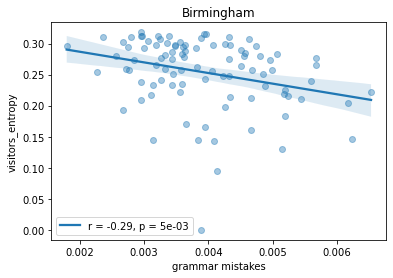

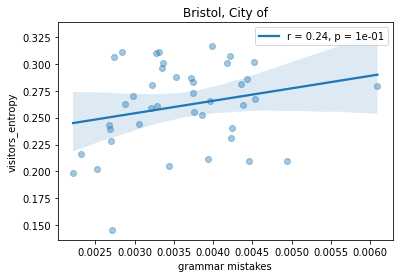

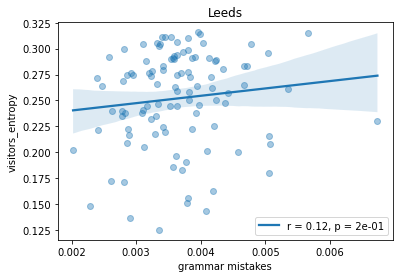

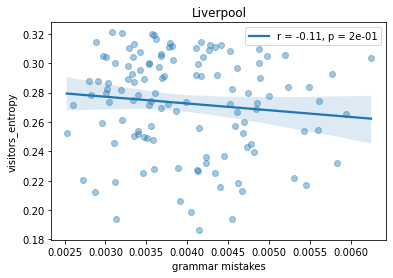

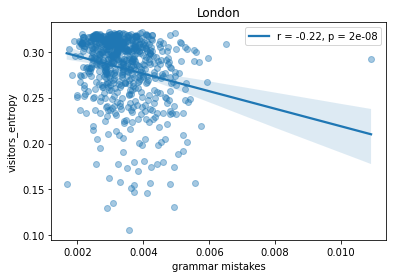

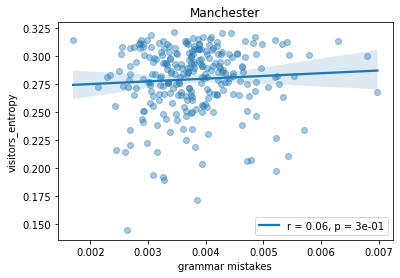

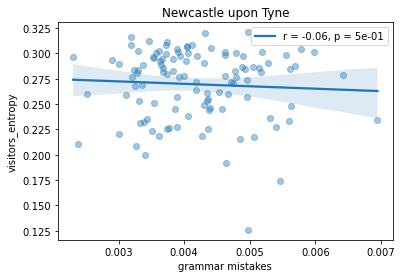

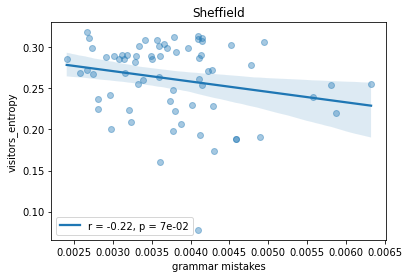

In [35]:
exclude_res_trips = True
nr_classes = 5
for city, city_d in lang.iter_subregs(
    subreg_df, ses_metric='net_income18', cat_id='GRAMMAR', include_pop=True
):
    city_d['cells_mask'] = None # already done in lang.iter_subregs
    cells_mistake = city_d.pop('cells_mistake')
    cell_entropies_df = ses_data.get_cell_entropies_df(
        nr_classes=nr_classes, exclude_res_trips=exclude_res_trips, **city_d
    )
    # cell_nr_visits = cells_subset_user_acty['count'].groupby('cell_id').sum()
    mask = slice(None) # cell_nr_visits > 1000
    x = cells_mistake
    # x = city_d['cells_ses_metric'].loc[mask]
    # y = cell_entropies_df.loc[mask, 'residents_entropy']
    y = cell_entropies_df.loc[mask, 'visitors_entropy']
    r, p = scipy.stats.pearsonr(x, y)
    fig, ax = plt.subplots()
    ax = sns.regplot(
        x=x,
        y=y,
        scatter_kws={'alpha': .4},
        line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
        ax=ax,
    )
    ax.legend()
    ax.set_title(city)

# Model with social mixing and income

## ABMs?

## ML

In [133]:
from copy import deepcopy
from tqdm import tqdm

import parallel as ms_parallel
# import machine_scientist.parallel as ms_parallel
from machine_scientist.fit_prior import read_prior_par

maybe try it with just income x grammar 

In [196]:
from sklearn.preprocessing import StandardScaler, RobustScaler
xscaler = StandardScaler()
X = pd.concat(
    [
        ses_values,
        cell_entropies_df['visitors_entropy'],
        cell_entropies_df['residents_entropy'],
    ],
    axis=1,
).reset_index(drop=True)
X_rescaled = pd.DataFrame(xscaler.fit_transform(X), columns=X.columns)
yscaler = StandardScaler()
y = cells_mistake.reset_index(drop=True)
y_rescaled = pd.Series(yscaler.fit_transform(y.to_frame())[:, 0], name=y.name)

### Initializing the Bayesian machine scienstist 

We start by initializing the machine scientist. This involves three steps:
- **Reading the prior hyperparameters.** The values of the hyperparameters depend on the number of variables `nv` and parameters `np`considered during the search. Many combinations of `nv` and `np` have hyperparameters calculated in the `Prior` directory. Otherwise, the hyperparameters should be fit. 
- **Setting the "temperatures" for the parallel tempering.** If you don't know what parallel tempering is, you can read it in the Methods section of the paper, or just leave it as is in the code. In general, more temperatures (here 20) lead to better sampling of the expression space (we use a maximum of 100 different temperatures)
- **Initializing the (parallel) scientist.**

In [197]:
# Set the temperatures for the parallel tempering
Ts = [1] + [1.04**k for k in range(1, 100)]
prior_par = read_prior_par(paths.ext_data / 'final_prior_param_sq.named_equations.nv13.np13.2016-09-01 17:05:57.196882.dat')
# Initialize the parallel machine scientist
pms = ms_parallel.Parallel(
    Ts,
    variables=X.columns.tolist(),
    parameters=['a%d' % i for i in range(X.shape[1])],
    x=X_rescaled, y=y_rescaled,
    prior_par=prior_par,
)

### Sampling expressions with the Bayesian machine scientist 

We are now ready to start sampling expressions with the Bayesian machine scientist, using MCMC. In its simplest form, one just needs to run the `mcmc_step()` and the `tree_swap()` methods as many times as necessary. `mcmc_step()` performs an MCMC update at each of the temperatures of the parallel tempering, whereas `tree_swap()` attempts to swap the expressions at two consecutive temperatures.

Typically, of course, one wants to do something other than just generate expressions. For example, one may want to keep track of the most plausible (or, equivalently, the minimum description length) model visited so far by the MCMC, or to keep a trace of some of the properties of the sampled expressions. The example below keeps the best model, as well as a trace of all the description lengths visited. Note that, in `Parallel` objects, the relevant expression is stored in the `t1` attribute (which stands for temperature 1).

In [198]:
# MCMC
description_lengths, mdl, mdl_model = [], np.inf, None

In [199]:
# Number of MCMC steps
nstep = 1000

for i in tqdm(range(nstep)):
    # MCMC update
    pms.mcmc_step() # MCMC step within each T
    pms.tree_swap() # Attempt to swap two randomly selected consecutive temps
    # Add the description length to the trace
    description_lengths.append(pms.t1.E)
    # Check if this is the MDL expression so far
    if pms.t1.E < mdl:
        mdl, mdl_model = pms.t1.E, deepcopy(pms.t1)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [06:08<00:00,  2.71it/s]


So let's take a look at the objects we stored. Here is the best model sampled by the machine scientist:

In [200]:
print('Best model:\t', mdl_model)
print('Desc. length:\t', mdl)

Best model:	 _a1_
Desc. length:	 100.707327963094


In [195]:
mdl_model.par_values

{'d0': {'_a0_': -2.1811441541785825e-12, '_a1_': 1.0, '_a2_': 1.0}}

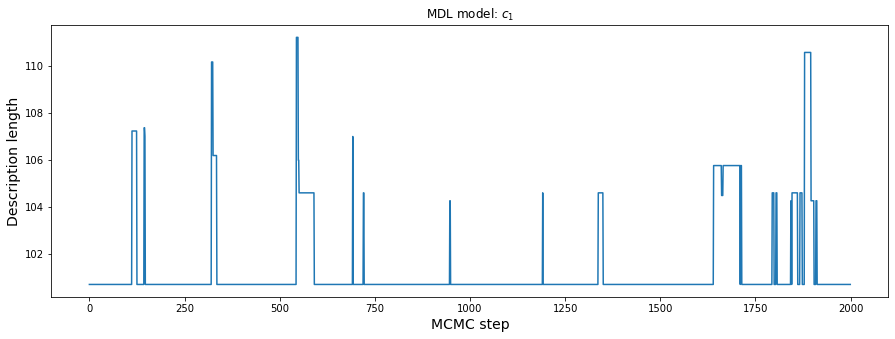

In [192]:
plt.figure(figsize=(15, 5))
plt.plot(description_lengths)
plt.xlabel('MCMC step', fontsize=14)
plt.ylabel('Description length', fontsize=14)
plt.title('MDL model: $%s$' % mdl_model.latex())
plt.show()